# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
# Imports here
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import workspace_utils 
from workspace_utils import active_session
from collections import OrderedDict
from torch.optim import lr_scheduler
import time
import os
from PIL import Image
import numpy as np
from random import randint
from workspace_utils import keep_awake
import json
from datetime import datetime

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
data_dir = "flowers"
train_dir = data_dir + "/train"
valid_dir = data_dir + "/valid"
test_dir = data_dir + "/test"

In [3]:
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

# TODO: Load the datasets with ImageFolder
train_data = datasets.ImageFolder(data_dir + "/train", transform = train_transforms)
test_data = datasets.ImageFolder(data_dir + "/test", transform = test_transforms)
valid_data = datasets.ImageFolder(data_dir + "/valid", transform = test_transforms)

# TODO: Using the image datasets and the trainforms, define the dataloaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size = 64, shuffle = True)
testloader = torch.utils.data.DataLoader(test_data, batch_size = 64)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size = 64)

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [4]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

**Note for Workspace users:** If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [5]:
def getModel(input_size, hidden_layers, drop_out, output_size, class_to_idx):
    """ 
        Load a pre-trained model from pytorch and define a new feed-forward network
        using ReLU and Dropout.
        Inputs:
            input_size (int): Size of the inputs tensor
            hidden_layers (tuple): tuple with the inputs of the 2 hidden layers
            drop_out (float): Percentaje of dropout layers
            outputsize (int): The total output expected. Must match with the number of classes to infer
            
        Return: A model object (torchvision.models.vgg.VGG)
    """
    model = models.vgg19(pretrained = True)
    model.class_to_idx = class_to_idx
    
    # Freeze parameters so we don't backprop through them
    for param in model.parameters():
        param.requires_grad = False

    model.classifier = nn.Sequential(OrderedDict([
                                    ("fc1", nn.Linear(input_size, hidden_layers)),
                                    ("relu1", nn.ReLU()),
                                    ("dropout1", nn.Dropout(p = drop_out)),
                                    ("fc2", nn.Linear(hidden_layers, output_size)),
                                    ("output", nn.LogSoftmax(dim = 1))
                                    ]))

        
    # Our model and data must be in the same device
    model.to(device)
    
    return model

model = getModel(25088, 3136, 0.2, 102, train_data.class_to_idx)

model

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.torch/models/vgg19-dcbb9e9d.pth
100%|██████████| 574673361/574673361 [00:05<00:00, 101847640.47it/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

In [6]:
# As we use LogSoftmax as output in our model we must stablish NLLLoss as our loss criterion
criterion = nn.NLLLoss()

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier.parameters(), lr = 0.001)

# We establish a decaying learning rate, we go "fast" at the beginning and slow and the end
scheduler = lr_scheduler.StepLR(optimizer, step_size = 3 , gamma = 0.1)

In [7]:
def testModel(model, test_data):
    """
        Test the model pass to the function
        Inputs:
            model (torchvision.models): model to test on test data
            
        Returns:
            test_loss (float): total loss in the test_data
            accuracy (float): total accuracy in the test_data
    """  
    test_loss = 0
    accuracy = 0
    equals = 0
    model.eval()
    
    with torch.no_grad():
        for inputs, labels in test_data:
            inputs, labels = inputs.to(device), labels.to(device)
            log_ps = model.forward(inputs)
            batch_loss = criterion(log_ps, labels)
            test_loss += batch_loss.item()

            # We take the exp because we used NLLLoss as criterion
            probabilities = torch.exp(log_ps) 
            equals = (labels.data == probabilities.max(dim=1)[1])
            accuracy += equals.type(torch.FloatTensor).mean()
            
    model.train()
    
    return test_loss, accuracy

In [8]:
def trainModel(model, epochs, print_every):
    """ 
        Function to train our model.
        Input:
            epochs (int): Number of epochs we want to train.
            model (torchvision.models): Model to train
    """
    total_time = time.time()
    model.train()
    print(f"Training device = {device}")

    for epoch in range(epochs):
        train_loss = 0.0
        start = time.time()
        steps = 0
        # Learning rate update(decaying)
        scheduler.step()
        
        for inputs, labels in trainloader:
            steps += 1
            
            # Move input and label tensors to the default device
            inputs, labels = inputs.to(device), labels.to(device)

            # Clear the gradients
            optimizer.zero_grad()
            
            # Forward pass
            log_ps = model.forward(inputs)

            # Calculating loss with softmax
            loss = criterion(log_ps, labels)

            # Backward propation
            loss.backward()

            # Updating gradients
            optimizer.step()

            train_loss += loss.item()
                
            if steps % print_every == 0:
                
                test_loss, accuracy = testModel(model, testloader) 
                
                print(f"Epoch {epoch+1}/{epochs}    Step: {steps}    "
                      f"Train loss: {train_loss / len(trainloader):.2f}    "
                      f"Test Loss: {test_loss / len(testloader):.2f}    ",
                      f"Test Accuracy: {accuracy / len(testloader) * 100:.2f} %")
        
        test_loss, accuracy = validModel(model, testloader)
        print(f"Epoch {epoch+1}/{epochs}    "
              f"Learning rate: {scheduler.get_lr()}   "
              f"Train loss: {train_loss / len(trainloader):.2f}    "
              f"Test Loss: {test_loss / len(testloader):.2f}    "
              f"Test Accuracy: {accuracy / len(testloader) * 100:.2f} %    "
              f"Time per epoch: {(time.time() - start):.2f} seconds"
              "\n**************")
    
    print(f"Total time training: {(time.time() - total_time):.2f} seconds")

for i in keep_awake(range(1)):
    trainModel(model, 6, 40)
    
print("Finished Training !!")

Training device = cuda
Epoch 1/6    Step: 40    Train loss: 2.14    Test Loss: 2.11     Test Accuracy: 49.17 %
Epoch 1/6    Step: 80    Train loss: 2.89    Test Loss: 1.14     Test Accuracy: 69.04 %
Epoch 1/6    Learning rate: [0.001]   Train loss: 3.23    Test Loss: 1.05    Test Accuracy: 72.02 %    Time per epoch: 235.57 seconds
**************
Epoch 2/6    Step: 40    Train loss: 0.48    Test Loss: 1.02     Test Accuracy: 72.83 %
Epoch 2/6    Step: 80    Train loss: 0.93    Test Loss: 0.72     Test Accuracy: 80.25 %
Epoch 2/6    Learning rate: [0.001]   Train loss: 1.17    Test Loss: 0.76    Test Accuracy: 77.91 %    Time per epoch: 222.31 seconds
**************
Epoch 3/6    Step: 40    Train loss: 0.38    Test Loss: 0.64     Test Accuracy: 82.42 %
Epoch 3/6    Step: 80    Train loss: 0.76    Test Loss: 0.59     Test Accuracy: 83.83 %
Epoch 3/6    Learning rate: [0.001]   Train loss: 0.95    Test Loss: 0.64    Test Accuracy: 81.27 %    Time per epoch: 229.44 seconds
**************
Ep

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [9]:
def ValidModel(model, test_data):
    """
        Test the model pass to the function
        Inputs:
            model (torchvision.models): model to test on test data
            
        Returns:
            test_loss (torch.FloatTensor): total loss in the test_data
            accuracy (torch.FloatTensor): total accuracy in the test_data
    """  
    test_loss = 0
    accuracy = 0
    equals = 0
    total = 0
    model.eval()
    
    with torch.no_grad():
        for inputs, labels in test_data:
            inputs, labels = inputs.to(device), labels.to(device)
            log_ps = model.forward(inputs)
            batch_loss = criterion(log_ps, labels)
            test_loss += batch_loss.item()

            # We take the exp because we used NLLLoss as criterion
            probabilities = torch.exp(log_ps)             
            equals = (labels.data == probabilities.max(dim=1)[1])
            accuracy += equals.type(torch.FloatTensor).mean()       
            
    print(f"Validation Loss: {test_loss / len(test_data):.2f}    ",
          f"Validation Accuracy: {(accuracy / len(test_data)) * 100:.2f} %")
            
    model.train()
    
    return test_loss, accuracy

In [10]:
test_loss, accuracy = testModel(model, valid_loader)

Validation Loss: 0.37     Validation Accuracy: 90.16 %


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [11]:
def saveModelCheckpoint(model, optimizer, name = "checkpoint.pth"):
    """
        Save the actual state of the model and its configuration as a checkpoint from which 
        we could later continue our training.
        Inputs:
            model (torchvision.models): the model we want to save the checkpoint.
            optimizer (torch.optim): the optimizer used in the model.
            name (string): the name of the checkpoint.
    """
    now = datetime.now()
    dt_string = "checkpoint_" + now.strftime("%d_%m_%Y") + ".pth"
    
    name = dt_string if name=="checkpoint.pth" else name
    
    torch.save({"model": model,
                "optimizer": optimizer,
                "input_size": model.classifier.fc1.in_features,
                "hidden_layers": model.classifier.fc2.in_features,
                "drop_out": model.classifier.dropout1.p,
                "output_size": model.classifier.fc2.out_features,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "class_to_idx": model.class_to_idx
               }, name)
    
    print(f"Checkpoint save in {os.getcwd()}/{name}")

saveModelCheckpoint(model, optimizer)

Checkpoint save in /home/workspace/aipnd-project/checkpoint_17_01_2020.pth


## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [13]:
def loadModelCheckpoint(checkpoint_path):
    """ 
        Load the checkpoint and return a model and an optimizer generated with its data.
        Inputs:
            name (string): the name of the checkpoint we want to load
            
        Returns:
            model (torchvision.models): the model build with the checkpoint data
            optimizer (torch.optim): the optimizer build with the state_dict
    """
    if torch.cuda.is_available():
        map_location=lambda storage, loc: storage.cuda()
    else:
        map_location='cpu'

    checkpoint = torch.load(checkpoint_path, map_location=map_location)

    model = checkpoint["model"]
   
    model.load_state_dict(checkpoint["model_state_dict"])
    
    optimizer = optim.Adam(model.classifier.parameters(), lr = 0.001)
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    model.to(device)
    
    print(f"Model checkpoint loaded: {checkpoint_path}")
    
    return model, optimizer

model, optimizer = loadModelCheckpoint("checkpoint_17_01_2020.pth")
model

Model checkpoint loaded: checkpoint_17_01_2020.pth


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [14]:
def process_image(image):
    ''' 
        Scales, crops, and normalizes a PIL image for a PyTorch model
        Input:
            image (string): path to the image
            
        Returns 
            np_image (numpy.array): numpy array with the image transform
    '''
    pil_image = Image.open(image)
    
    image_transforms = transforms.Compose([transforms.Resize(256),
                                           transforms.CenterCrop(224),
                                           transforms.ToTensor()])
    
    pil_image = image_transforms(pil_image).float()
    
    np_image = np.array(pil_image).transpose(1, 2, 0)
                                     
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    np_image = np_image - mean/std
    np_image = np.transpose(np_image, (2, 0, 1))
    
    return np_image

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [15]:
def imshow(image, ax=None, title=None):
    """
        Imshow for Tensor
    """
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

To Check if previous functions work properly we process a randon imagen. For this we define a function that select a random image from one of the folders (train, test, valid). Optinally we can also select the class we want to show, otherwise it will be selected randomly.

In [16]:
def randomImage(folder, flower_class = 0):
    """
        Return the path of a random image. If no class is received it is randomly choosen
        Inputs:
            folder (string): must one among ("train", "test", "valid")
            flower_class (int): optional parameter. Number of the class
            
        Return:
            image_path (string): path to the random image
    """
    if folder not in ("train", "test", "valid"):
        print("Invalid folder.")
    else:
        # If there is no flower class choosen it is randomly chose
        flower_class = randint(0,102) if flower_class == 0 else flower_class

        class_path = os.getcwd() + "/flowers/" + folder + "/" + str(flower_class)

        # Create a list with the images in the folder class
        images_list = os.listdir(class_path)
        
        # Chose one of them randomly
        random_image = images_list[randint(0, len(images_list) - 1)]

        # Image path
        image_path = class_path + "/" + random_image

        return image_path

/home/workspace/aipnd-project/flowers/valid/85/image_04818.jpg


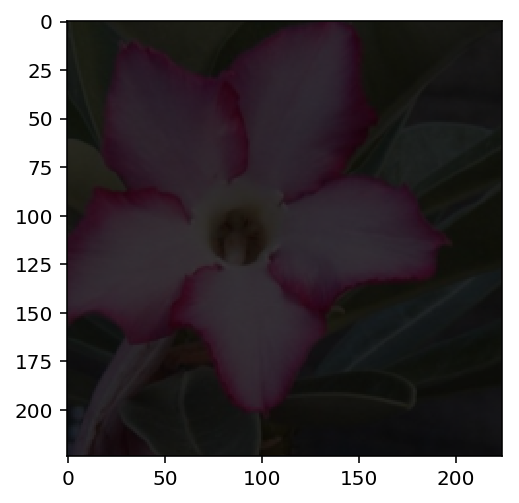

In [17]:
random_image = randomImage("valid")
check_image = process_image(random_image)
imshow(check_image)
print(random_image)

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [18]:
def predict(image_path, model, topk=5):
    ''' 
        Predict the class (or classes) of an image using a trained deep learning model.
        Inputs:
            image_path (string): path to the image
            model (torchvision.models): model used for the prediction
            topk (int): top k more likely classes
        
        Returns:
            top_probabilities (list): list with the topk probabilities
            top_classes (list): list with the topk classes
    '''
    print(image_path)
    image = torch.from_numpy(process_image(image_path)).float().unsqueeze_(0).to(device)

    # Get the class probabilities, as we used NLLLoss as criterion we take the exponential
    ps = torch.exp(model(image))
    top_probabilities, top_classes = ps.topk(topk, dim=1)
     
    top_probabilities = top_probabilities.detach().cpu().numpy().reshape(-1).tolist()
    top_classes = top_classes.cpu().numpy()
    
    top_probabilities = np.around(top_probabilities, decimals = 4)
    
    to_list = []
    for i in range(topk):
        to_list.append(cat_to_name[str(top_classes[0][i])])
        
    top_classes = to_list
    
    return top_probabilities, top_classes

In [19]:
random_image = randomImage("valid", 5)
top_probabilities, top_classes = predict(random_image, model.to(device))

print(f"probabilities: {top_probabilities} ")
print(f"classes: {top_classes}")

/home/workspace/aipnd-project/flowers/valid/5/image_05199.jpg
probabilities: [ 0.8924  0.033   0.0225  0.0158  0.0107] 
classes: ['marigold', 'sunflower', 'great masterwort', 'bishop of llandaff', 'purple coneflower']


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [20]:
def testModel(model, flower_class):
    """
        Test the model showing the image and the probabilities predicted
        Inputs:
            model (torchvision.models): model to test
            flower_class (int): class of the flower to test
    """   
    image_path = randomImage("valid", flower_class)
    #image_path = "/home/workspace/aipnd-project/flowers/valid/85/image_04799.jpg"
    image = process_image(image_path)
    
    
    # Obtain the prob and the classes
    top_probabilities, top_classes = predict(image_path, model)
    
    fig, (ax_image, ax_probs) = plt.subplots(figsize=(6,6), nrows=2)
    ax_image.axis('off')
    with Image.open(image_path) as img:
        ax_image.imshow(img)
    ax_image.title.set_text(cat_to_name[str(flower_class)])
    ax_probs.barh(np.arange(len(top_classes)), top_probabilities)
    ax_probs.set_yticklabels(top_classes)
    ax_probs.set_yticks(np.arange(len(top_classes)))
    ax_probs.invert_yaxis()

/home/workspace/aipnd-project/flowers/valid/5/image_05192.jpg


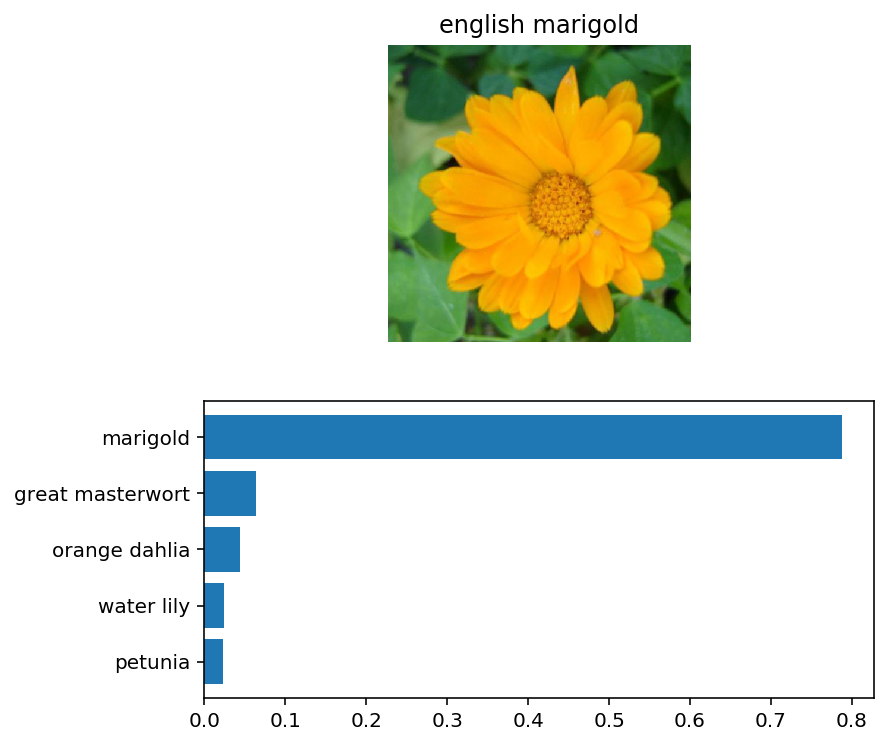

In [22]:
testModel(model, 5)